In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 数据来源 https://archive.ics.uci.edu/ml/datasets/Census+Income

data = pd.read_csv("../data/adult.data", sep=",", header=None)
test = pd.read_csv("../data/adult.test", sep=",", header=None)


In [65]:
data.replace("\s+", '', regex=True, inplace=True)  #去除空格
train = data.replace({'?': np.nan}).dropna()  #清除缺失属性的数据
test.replace("\s+", "", regex=True, inplace=True)
test.replace({'?': np.nan}).dropna()

(train_length, _) = train.values.shape
(test_length, _) = test.values.shape
print((train_length, test_length))

(30162, 16281)


In [66]:
tmp = np.concatenate((train.values, test.values), axis=0)
print(tmp.shape)


(46443, 15)


In [67]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
tmp=all.values
print(tmp.shape)
#切割数据
tmp_x = tmp[:, 0:-1]
tmp_y = tmp[:, -1]
tmp_y[tmp_y == '<=50K'] = '<50K'
tmp_y[tmp_y == "<=50K."] = '<50K'
tmp_y[tmp_y == '>50K.'] = '>50K'
print(tmp_x.shape)
print(tmp_y.shape)
# 字符串属性更改为数字
# 标签更改为数字
tmp_x[:, 1] = LabelEncoder().fit_transform(tmp_x[:, 1])
tmp_x[:, 3] = LabelEncoder().fit_transform(tmp_x[:, 3])
tmp_x[:, 5] = LabelEncoder().fit_transform(tmp_x[:, 5])
tmp_x[:, 6] = LabelEncoder().fit_transform(tmp_x[:, 6])
tmp_x[:, 7] = LabelEncoder().fit_transform(tmp_x[:, 7])
tmp_x[:, 8] = LabelEncoder().fit_transform(tmp_x[:, 8])
tmp_x[:, 9] = LabelEncoder().fit_transform(tmp_x[:, 9])
tmp_x[:, 13] = LabelEncoder().fit_transform(tmp_x[:, 13])
tmp_y = LabelEncoder().fit_transform(tmp_y)
print(tmp_x[0, :])
print(tmp_x.dtype)
print(tmp_y)
#更改类型
tmp_x = tmp_x.astype(np.float32)
tmp_y = tmp_y.astype(np.int32)
tmp_y = np.expand_dims(tmp_y, axis=1)
print(tmp_x.dtype)
print(tmp_x[0, :])
tmp_x = MinMaxScaler().fit_transform(tmp_x)
train_x = tmp_x[0:train_length, :]
test_x = tmp_x[train_length:, ]
train_y = tmp_y[0:train_length]
test_y = tmp_y[train_length:]
print(train_y.shape)
print(test_y.shape)
np.savez("../data/adult_binary.npz", train_x=train_x, test_x=test_x, train_y=train_y, test_y=test_y)

(46443, 15)
(46443, 14)
(46443,)
[39 7 77516 9 13 4 1 1 4 1 2174 0 40 39]
object
[0 0 0 ... 0 0 1]
float32
[3.9000e+01 7.0000e+00 7.7516e+04 9.0000e+00 1.3000e+01 4.0000e+00
 1.0000e+00 1.0000e+00 4.0000e+00 1.0000e+00 2.1740e+03 0.0000e+00
 4.0000e+01 3.9000e+01]
(30162, 1)
(16281, 1)


In [68]:
from torch import optim
from torch.optim import Adam, lr_scheduler
from torch.nn import Sequential
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score


# 参考microsoft/ai-edu
# https://github.com/microsoft/ai-edu/blob/master/%E5%9F%BA%E7%A1%80%E6%95%99%E7%A8%8B/A2-%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E5%9F%BA%E6%9C%AC%E5%8E%9F%E7%90%86/%E7%AC%AC7%E6%AD%A5%20-%20%E6%B7%B1%E5%BA%A6%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C/src/ch14-DnnBasic/Level4_IncomeClassifier.py
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = Sequential(
            nn.Linear(14, 32, bias=True),
            nn.ReLU(),
            nn.Linear(32, 16, bias=True),
            nn.ReLU(),
            nn.Linear(16, 8, bias=True),
            nn.ReLU(),
            nn.Linear(8, 4, bias=True),
            nn.ReLU(),
            nn.Linear(4, 1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


max_epoch = 100
batch_size = 16
lr = 0.1
train_data_x, val_data_x = torch.utils.data.dataset.random_split(train_x, [27146, 3016],
                                                                 generator=torch.Generator().manual_seed(42))
train_data_y, val_data_y = torch.utils.data.dataset.random_split(train_y, [27146, 3016],
                                                                 generator=torch.Generator().manual_seed(42))
train_data = DataLoader(
    dataset=TensorDataset(torch.FloatTensor(train_data_x), torch.LongTensor(train_data_y)),
    batch_size=batch_size,
    shuffle=True)
valid_x, valid_y = torch.FloatTensor(val_data_x), torch.LongTensor(val_data_y)
test_x, test_y = torch.FloatTensor(test_x), torch.LongTensor(test_y)

model = Model()
loss_func = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=lr)
scheduler=lr_scheduler.ExponentialLR(optimizer,gamma=0.1)
valid_loss = []
train_loss = []

for epoch in range(max_epoch):
    epoch_loss = []
    for step, (batch_x, batch_y) in enumerate(train_data):
        pred = model(batch_x)
        loss = loss_func(pred, batch_y.float())  #类型统一
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.cpu().data)
    scheduler.step()
    train_loss.append(np.mean(epoch_loss))
    valid_pred = model(valid_x)
    loss = loss_func(valid_pred, valid_y.float())
    valid_loss.append(loss.cpu().data)
    valid_pred = valid_pred.detach().numpy()
    valid_pred[valid_pred < 0.5] = 0
    valid_pred[valid_pred >= 0.5] = 1
    acc = accuracy_score(valid_pred, valid_y)
    print(f"epoch: {epoch} train_loss: {np.mean(epoch_loss)}, valid_loss: {loss.cpu().data}, acc={acc}")

pred = model(test_x)
loss = loss_func(pred, test_y.float()).cpu().data


epoch: 0 train_loss: 0.5615741014480591, valid_loss: 0.5621368885040283, acc=0.7543103448275862
epoch: 1 train_loss: 0.5620302557945251, valid_loss: 0.5577875971794128, acc=0.7543103448275862
epoch: 2 train_loss: 0.5616046786308289, valid_loss: 0.557550847530365, acc=0.7543103448275862
epoch: 3 train_loss: 0.5615805983543396, valid_loss: 0.557555079460144, acc=0.7543103448275862
epoch: 4 train_loss: 0.5616196990013123, valid_loss: 0.5575554370880127, acc=0.7543103448275862
epoch: 5 train_loss: 0.5615450143814087, valid_loss: 0.557555615901947, acc=0.7543103448275862
epoch: 6 train_loss: 0.5615695714950562, valid_loss: 0.5575556755065918, acc=0.7543103448275862
epoch: 7 train_loss: 0.5615449547767639, valid_loss: 0.5575556755065918, acc=0.7543103448275862
epoch: 8 train_loss: 0.5615449547767639, valid_loss: 0.5575556755065918, acc=0.7543103448275862
epoch: 9 train_loss: 0.5615695714950562, valid_loss: 0.5575556755065918, acc=0.7543103448275862
epoch: 10 train_loss: 0.5615449547767639, v

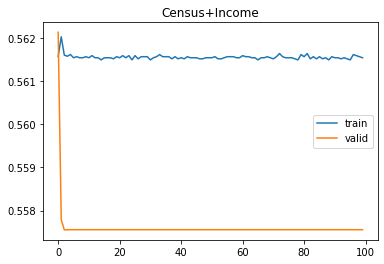

In [70]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(max_epoch)],train_loss)
plt.plot([i for  i in range(max_epoch)],valid_loss)
plt.title("Census+Income")
plt.legend(["train","valid"])
plt.show()